### Kaggle: Contradictory, My Dear Watson
S. Michael

**Objectives:**
1.   to create a Natural Language Inferencing (NLI) model that assigns labels of 0, 1, or 2 (corresponding to entailment, neutral, and contradiction) to pairs of premises and hypotheses.
2.   to predict whether a given hypothesis is related to its premise by entailment, contradiction or whether neither of those is true (neutral) on new, unlabeled text (test.csv).

Given two sentences, a "premise" and a "hypothesis", determine whether:
*   "hypothesis" follows logically from "premise" ("entailment")
*   "hypothesis" has no effect on "premise" ("neutral")
*  "hypothesis" contradicts "premise" ("contradiction")

**Specific Challenge:** Kaggle's contradictory-my-dear-watson, Contradictory, My Dear Watson

*Note: The train and test data provided by Kaggle includes text in fifteen different languages.*


Data Source: https://www.kaggle.com/competitions/contradictory-my-dear-watson/data

 **Methodology**

*Bidirectional Encoder Representations from Transformers (BERT)*

To tackle this multi-lingual, multi-classification modeling challenge, the transformer-based architecture, BERT, will be used to capture the relationships between premise-hypothesis pairs. Transformers are deep neural netowrks with an attention mechanism that can process text input all at once, rather the word-by-word method of tradional NLP models.

Transformer-based machile learning models learn to pay attention to the most important words and phrases with the use of an encoder, or a stack of transformer layers. Unlike other models with attention mechanisms which implement both an encode and a decoder, BERT models use only an encoder.

Pretrained on vast amounts of data with the primary objectives of masked language modeling (MLM) and next sentence prediction (NSP), BERT models learn the underlying structure and meaning of language, making them highly effective for NLP tasks. Once pre-trained, BERT models can be fine-tuned for specific tasks, which allows them to adapt to the specific nuances of the NLP task and improve performance.

BERT models are used for a wide variety of NLP tasks, including inference. This challenge uses the BERT pre-trained models:

*   'bert_base_multi',     
*   'distil_bert_base_multi'

Recognized for their inference abilities, the three BERT models above are pretrained on multiple languages.



**'bert_base_multi'**
> 'Pretrained model on the top 102 languages with the largest Wikipedia using a masked language modeling (MLM) objective. . .This model is uncased: it does not make a difference between english and English (https://huggingface.co/bert-base-multilingual-cased).'

**distil_bert_base_multi'**
> 'Pretrained model on the top 102 languages with the largest Wikipedia using a masked language modeling (MLM) objective. . .This model is uncased: it does not make a difference between english and English (https://huggingface.co/bert-base-multilingual-cased).'
















**Steps:**
1. Switch to TPU or GPU, if possible
2. Import libraries
3. Download Data: kaggle contradictory-my-dear-watson
4. Explore Data: train.csv & test.csv
5. Visualize Data: train & test
6. Data Preparation, Training, & Validating
7. Make Predictions on test & Create Submission Files
8. Challlenges and Future Work

### **Import Libraries**

In [ ]:
!pip install keras-nlp tensorflow==2.11 tensorflow-text==2.11
!pip install --upgrade tensorflow
!pip install --upgrade tensorflow-text
!pip install --upgrade keras
!pip install keras-tuner --upgrade

In [ ]:
!pip freeze

In [ ]:
#env set up, download & read data
import os, csv, gc

os.environ["KERAS_BACKEND"] = "tensorflow"
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]="false"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".XX"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"]="platform"

#!pip install kaggle
#from kaggle.api.kaggle_api_extended import KaggleApi
from zipfile import ZipFile

#explore data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#data preprocess, fit
import keras
import keras_nlp
import tensorflow as tf
from keras import callbacks
from sklearn.model_selection import train_test_split

#use mixed precision to speed up all training
keras.mixed_precision.set_global_policy("mixed_float16")

In [ ]:
print(keras.__version__)
print(keras_nlp.__version__)
print(tf.__version__)

3.0.5
0.8.1
2.15.0


### **Download Data: kaggle contradictory-my-dear-watson**

In [ ]:
!mkdir ~/.kaggle
!echo '{"username":"sherylmichael","key":"ee2137bd8d95cc0d1f29d42dc871a87d"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c contradictory-my-dear-watson
# Read train & test data
ZipFile('contradictory-my-dear-watson.zip').extractall('data')
#os.chdir('/Users/sherilyn/ds_jungle/nlp/nli/data')

mkdir: cannot create directory ‘/root/.kaggle’: File exists
contradictory-my-dear-watson.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
submission = pd.read_csv('data/sample_submission.csv')

### **Explore Data: train.csv & test.csv**

In [ ]:
print('submission: ', submission.shape, '\n', submission.info(), '\n', submission.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5195 entries, 0 to 5194
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          5195 non-null   object
 1   prediction  5195 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 81.3+ KB
submission:  (5195, 2) 
 None 
            id  prediction
0  c6d58c3f69           1
1  cefcc82292           1
2  e98005252c           1
3  58518c10ba           1
4  c32b0d16df           1


In [ ]:
print("train:", train.shape, '\n', train.head())
print("\ntest:", test.shape, '\n', test.head())

train: (12120, 6) 
            id                                            premise  \
0  5130fd2cb5  and these comments were considered in formulat...   
1  5b72532a0b  These are issues that we wrestle with in pract...   
2  3931fbe82a  Des petites choses comme celles-là font une di...   
3  5622f0c60b  you know they can't really defend themselves l...   
4  86aaa48b45  ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...   

                                          hypothesis lang_abv language  label  
0  The rules developed in the interim were put to...       en  English      0  
1  Practice groups are not permitted to work on t...       en  English      2  
2              J'essayais d'accomplir quelque chose.       fr   French      0  
3  They can't defend themselves because of their ...       en  English      0  
4    เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร       th     Thai      1  

test: (5195, 5) 
            id                                            premise  \
0  c

In [ ]:
print('train.info():')
print(train.info())
print('\ntest.info():')
print(test.info())

train.info():
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12120 entries, 0 to 12119
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          12120 non-null  object
 1   premise     12120 non-null  object
 2   hypothesis  12120 non-null  object
 3   lang_abv    12120 non-null  object
 4   language    12120 non-null  object
 5   label       12120 non-null  int64 
dtypes: int64(1), object(5)
memory usage: 568.2+ KB
None

test.info():
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5195 entries, 0 to 5194
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          5195 non-null   object
 1   premise     5195 non-null   object
 2   hypothesis  5195 non-null   object
 3   lang_abv    5195 non-null   object
 4   language    5195 non-null   object
dtypes: object(5)
memory usage: 203.1+ KB
None


In [ ]:
print('class labels:', np.unique(train.label))
# summarize distribution train
print('unique values by column (train): \n', train.nunique(axis=0))
print('train.language.value_counts(dropna=False): \n', train.language.value_counts(dropna=False))
print('labels of 0, 1, and 2 correspond to entailment, neutral, and contradiction')
print('train.label.value_counts(dropna=False):\n', train.label.value_counts(dropna=False))
# summarize distribution train
print('\nunique values by column (test): \n', test.nunique(axis=0))
print(test.language.value_counts(dropna=False))

class labels: [0 1 2]
unique values by column (train): 
 id            12120
premise        8209
hypothesis    12119
lang_abv         15
language         15
label             3
dtype: int64
train.language.value_counts(dropna=False): 
 language
English       6870
Chinese        411
Arabic         401
French         390
Swahili        385
Urdu           381
Vietnamese     379
Russian        376
Hindi          374
Greek          372
Thai           371
Spanish        366
Turkish        351
German         351
Bulgarian      342
Name: count, dtype: int64
labels of 0, 1, and 2 correspond to entailment, neutral, and contradiction
train.label.value_counts(dropna=False):
 label
0    4176
2    4064
1    3880
Name: count, dtype: int64

unique values by column (test): 
 id            5195
premise       4336
hypothesis    5195
lang_abv        15
language        15
dtype: int64
language
English       2945
Spanish        175
Russian        172
Swahili        172
Urdu           168
Greek          168
T

In [ ]:
# check for missing data train
print('missing data, train: ', train.isnull().sum())
# check for missing data test
print('\nmissing data, test: ', test.isnull().sum())

missing data, train:  id            0
premise       0
hypothesis    0
lang_abv      0
language      0
label         0
dtype: int64

missing data, test:  id            0
premise       0
hypothesis    0
lang_abv      0
language      0
dtype: int64


#### **Summary of datasets: train, test**

train is a labeled dataset with 6 columns (id, premise, hypothesis, lang_abv, language, label) and 12120 rows.

train missing data: none
all train feature and target (label) variables are categorical.

test is a dataset with 5 columns (id, premise, hypothesis, lang_abv, language) and  5195 rows.
test missing data: none
all test features are categorical.

Exploration of train's class distribution suggests that the number of observations in each label class is balanced. However, there exists predominantly more text in the language, English (~57%), than in the other 14 languages. Distribution across the non-English languages appears to be balanced.

This langauge distribution is similar to that found in the test data, with ~57% of text representing the English language. Again, text seems balanced across the other 14 languages.

Data will be stratified by target when split for the training process.

In [ ]:
# Garbage Collection
gc.collect()

0

### **Visualize Data: train & test**

**train: Distribution by Label**

entailment count (0):  4176 
neutral count (1):  3880 
contradiction count (2):  4064


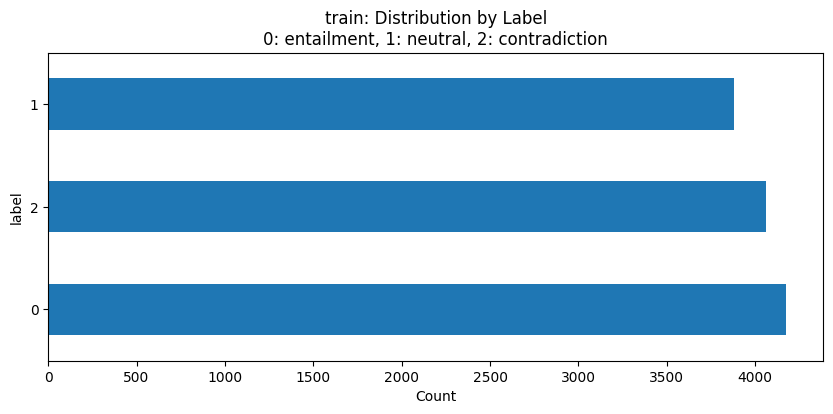

In [ ]:
#print('train.label.value_counts(dropna=False): \n', train.label.value_counts(dropna=False))
train.label.value_counts(ascending=False).plot(kind='barh', title='train: Distribution by Label\n0: entailment, 1: neutral, 2: contradiction', xlabel='Count',figsize=(10, 4))
entailment,contradiction, neutral = train.label.value_counts()
print('entailment count (0): ', entailment, '\nneutral count (1): ', neutral, '\ncontradiction count (2): ', contradiction)

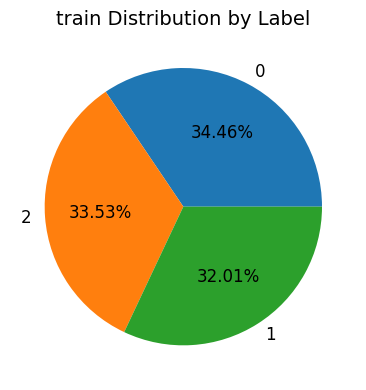

In [ ]:
v_counts = train.label.value_counts()
total = len(train.label)
fig = plt.figure(figsize=(4,4))
plt.pie(v_counts, labels=v_counts.index, autopct='%1.2f%%', textprops={'fontsize':12})
plt.title('train Distribution by Label', fontsize=14, fontdict={"fontsize":14})
plt.tight_layout()
plt.show()

train data is balanced across the target, label.

**train: Distribution by Language**

<Axes: title={'center': 'train: Distribution by Language'}, xlabel='Count', ylabel='language'>

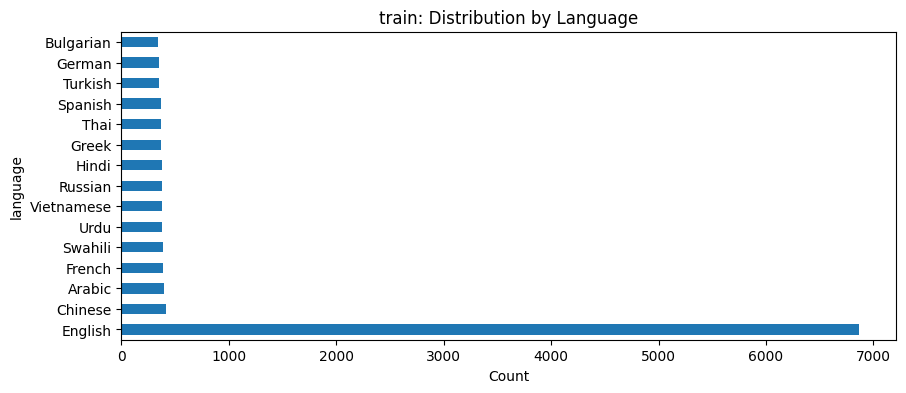

In [ ]:
#print('train.language.value_counts(dropna=False): \n', train.language.value_counts(dropna=False))
train.language.value_counts().plot(kind='barh', title='train: Distribution by Language', xlabel='Count',figsize=(10, 4))

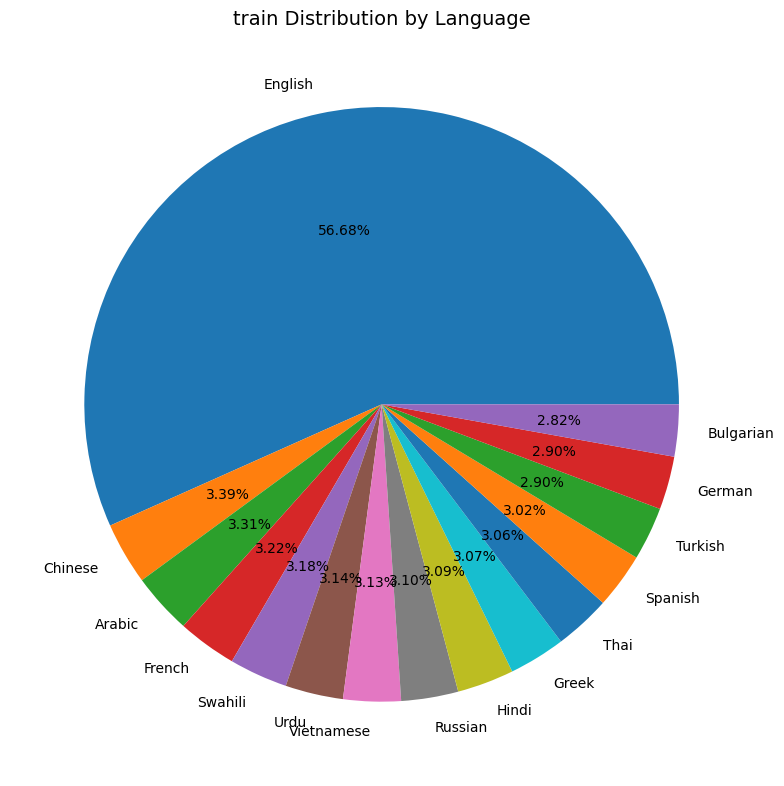

In [ ]:
v_counts = train.language.value_counts()
total = len(train.language)
fig = plt.figure(figsize=(8,8))
plt.pie(v_counts, labels=v_counts.index, autopct='%1.2f%%', textprops={'fontsize':10})
plt.title('train Distribution by Language', fontsize=14, fontdict={"fontsize":14})
plt.tight_layout()
plt.show()

Of the 15 languages present in the data, train, English represents ~57% text. The remaining ~42% is seemingly balanced across the remaining 14 languages.

**test: Distribution by Language**

<Axes: title={'center': 'test: Distribution by Language'}, xlabel='Count', ylabel='language'>

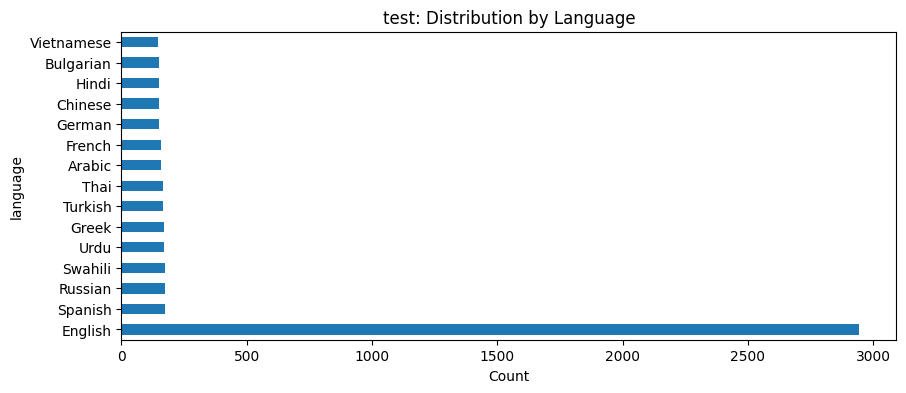

In [ ]:
#print('test.language.value_counts(dropna=False): \n', test.language.value_counts(dropna=False))
test.language.value_counts().plot(kind='barh', title='test: Distribution by Language', xlabel='Count',figsize=(10, 4))

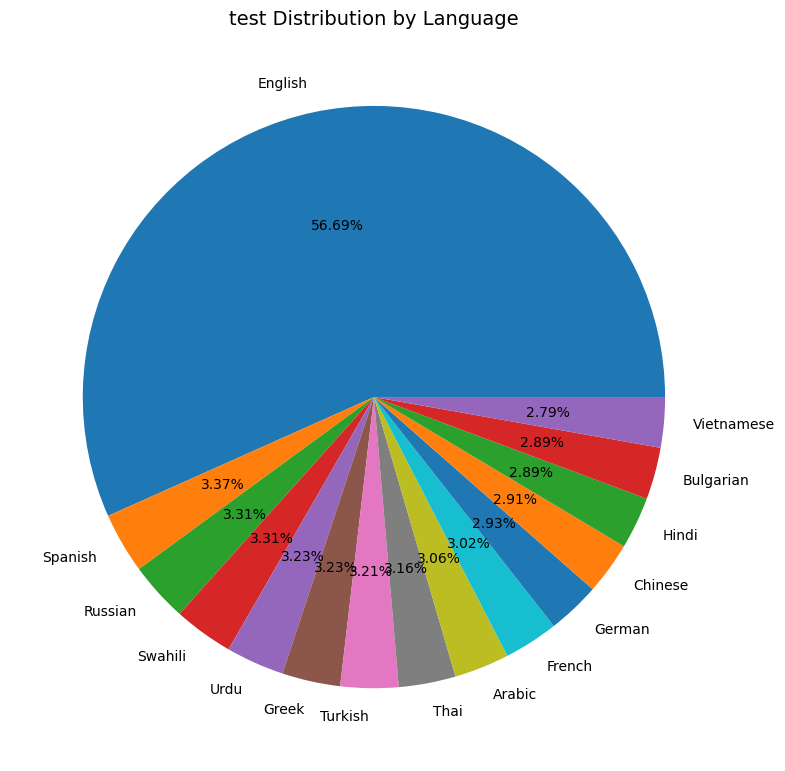

In [ ]:
v_counts = test.language.value_counts()
total = len(test.language)
fig = plt.figure(figsize=(8,8))
plt.pie(v_counts, labels=v_counts.index, autopct='%1.2f%%', textprops={'fontsize':10})
plt.title('test Distribution by Language', fontsize=14, fontdict={"fontsize":14})
plt.tight_layout()
plt.show()

The same 15 languages are found in both train and test. While the order of prevalence of the non-English languages change, the distributions of these 14 languages are relatively balanced. Like the data, train, test is predominantly English (~57%).

**train: Distribution by Label, Language**

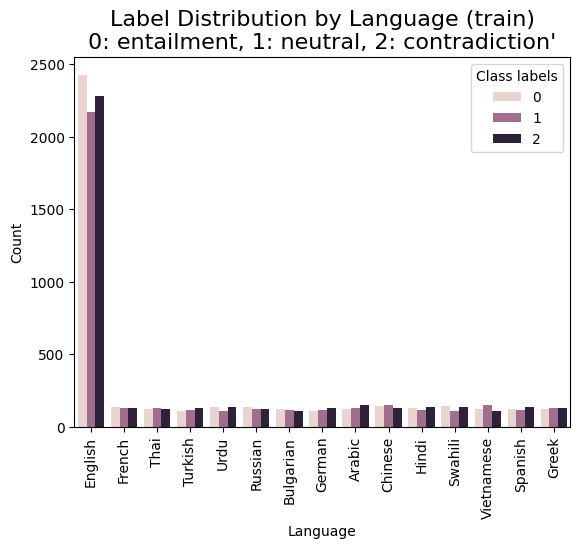

In [ ]:
sns.countplot(data=train, x="language", hue="label")
plt.xticks(rotation=90)
plt.title("Label Distribution by Language (train)\n0: entailment, 1: neutral, 2: contradiction'", fontsize=16)
plt.xlabel("Language")
plt.ylabel("Count")
plt.legend(title="Class labels")
plt.show()

Distribution of the target, label, is balanced within the languages in the dataset, train.

In [ ]:
# Garbage Collection
gc.collect()

0

### **Data Preparation**


 Text inputs need to be converted into numbers and assembled into tensors for model handling. Tokenizers accomplish these tasks by splitting text into tokens and converting them to numbers which are used to build tensors as inout for the model.

Tokenization with BERT(base) models pretrained with specific vocabulary prepares model inputs by applying the same vocabulary and token-index mapping to the data being analyzed.

The vocabulary as well as token-index mapping, can be downloaded using Bert tokenizer variants from the transformers library. BERT uses WordPiece vocabulary with a vocab size of around 30,000.

Additionally, input to BERT architecture must be in the same format in which BERT was pretrained. BERT uses two special tokens, classification -[CLS] and [SEP], to designate the first and last tokens in a input sequence, respectively.

BERT takes all the inputs as a single sequence. Because this challenge requires two inputs, premise and hypothesis, [SEP] tokens between these inputs will help the model understand input properly:

[CLS] premise [SEP] hypothesis [SEP]

For example, the input format for the premise and hypothesis:

> Premise: Sheri's doctor is running late for her appointment.

> Hypothesis: Sheri will be late meeting her son for lunch.

will be:

> Input Format:
[CLS] Sheri's doctor is running late for her appointment. [SEP] Sheri will be late meeting her son for lunch. [SEP]

BERT tokenizers simplify text processing by integrating normalization and pre-tokenization into the tokenization process.

Thus, to prepare raw text for transformer-based training with BERT's architecture, the text needs to be:
1.   Put data into the input format identified above,
2.   Tokenized and converted to vectorized form, and
3. Batched (vectorized tokens) for training, validation and test set

To help form tensor objects, padding and truncation will be used during the encoding process so that text inputs are the same length. BERT tokenizers max token text length out at 512. However, computation and time resources can be saved if this max length is known to be less than this max value.

The library, keras_nlp, will be used to prepare, compile and fit the premise:hypothesis data. KerasNLP models have built-in tokenization and compilation capabilities that handle tokenization and comilation with defaults based on the selected model. These models will tokenize all the strings of tuple inputs, concatenate them with a "[SEP]" separator, and instantiate the model.

Variants of a Bert preprocessing layer specific to the respective Bert pretrained models will tokenize input segments, pack inputs into necessary formatting using a keras_nlp.layers.MultiSegmentPacker, and construct a dictionary with with keys "token_ids", "segment_ids", "padding_mask", that can be passed directly to a BERT model (https://keras.io/api/keras_nlp/models/bert/bert_preprocessor/)

These Bert preprocessing layers will also compile with defaults and instantiate respective models with pretrained weights simply by calling .fit().

BERT variants from KerasNLP models will provide a baseline for the inference or semantic modeling task at-hand. Recompiling the respective BERT model with the highest performer on the metric, test_accuracy, with hyperparameter tuning will be done to increase model predictive abilitiy.

Before putting the data into the format above, the data, train, will be split --> train:val:test, 60:20:20.

> sklearn.model_selection.train_test_split will be used to create the training, validation and test sets for training and evaluating classifiers. The following parameter values will be used:


> val_test_size=0.40, test_size=0.5 (This defines the train:val:test ratio to be 60:20:20)

> stratify=train.target: (To help minimize bias, random stratified sampling by target will create train, val, and test datasets)

Data will also be converted to tensorflow Datasets using tf.data.Dataset.from_tensor_slices()

In [ ]:
#split into train, val, test
training, val_test = train_test_split(train, test_size=.4)
val, test = train_test_split(val_test, test_size=.5)
print('train.shape: ', train.shape, 'training.shape: ', training.shape, 'val.shape: ', val.shape, 'test.shape: ', test.shape)

#convert to tf Dataset
training_ds = tf.data.Dataset.from_tensor_slices(training.to_dict(orient="list"))
print(training_ds)
val_ds = tf.data.Dataset.from_tensor_slices(val.to_dict(orient="list"))
test_ds = tf.data.Dataset.from_tensor_slices(test.to_dict(orient="list"))

train.shape:  (12120, 6) training.shape:  (7272, 6) val.shape:  (2424, 6) test.shape:  (2424, 6)
<_TensorSliceDataset element_spec={'id': TensorSpec(shape=(), dtype=tf.string, name=None), 'premise': TensorSpec(shape=(), dtype=tf.string, name=None), 'hypothesis': TensorSpec(shape=(), dtype=tf.string, name=None), 'lang_abv': TensorSpec(shape=(), dtype=tf.string, name=None), 'language': TensorSpec(shape=(), dtype=tf.string, name=None), 'label': TensorSpec(shape=(), dtype=tf.int32, name=None)}>


In [ ]:
#load data into tensorflow dataset
AUTO = tf.data.AUTOTUNE

def split_labels(data):
    x = (data['hypothesis'], data['premise'])
    y = data['label']
    return x, y

train_ds = (training_ds.map(split_labels, num_parallel_calls=AUTO).batch(16))
val_ds = (val_ds.map(split_labels, num_parallel_calls=AUTO).batch(16))
test_ds = (test_ds.map(split_labels, num_parallel_calls=AUTO).batch(16))

In [ ]:
#define max token length
max_length = 512

batch_size = 32
epochs = 6
total_steps = sum(1 for _ in train_ds.as_numpy_iterator()) * epochs
warmup_steps = int(total_steps * 0.2)

#pre-trained multi-lingual presets to be compared (source: https://keras.io/api/keras_nlp/models/)
bert_presets = {
    'bert_base_multi': [keras_nlp.models.BertPreprocessor, keras_nlp.models.BertClassifier],
    'distil_bert_base_multi': [keras_nlp.models.DistilBertPreprocessor, keras_nlp.models.DistilBertClassifier]
}

predictions=[]

In [ ]:
def baseline_model(key, train_ds, val_ds, test_ds, test):
        print(key, ': baseline model')
        bert_classifier = bert_presets.get(key)[1].from_preset(key, num_classes=3)
        checkpoint = callbacks.ModelCheckpoint('bert_model.keras')
        print('\nfitting baseline model')
        bert_classifier.fit(train_ds, validation_data=val_ds, epochs=epochs, verbose=2)
        #evaluate performance on test_ds
        print('\nevaluating baseline model--> test_ds')
        loss, accuracy = bert_classifier.evaluate(test_ds, verbose=2)
        print('bert_model.keras, test_accuracy: {:5.2f}%'.format(100 * accuracy))
        prediction = bert_classifier.predict((test['premise'],test['hypothesis']), batch_size=batch_size, verbose=2)
        return loss, accuracy, prediction


In [ ]:
#hyperparameter tuning to increase model performance
def hypertun_model(key, train_ds, val_ds, test_ds, test):
        print(key, ': hypertuned model')
        tuned_classifier = bert_presets.get(key)[1].from_preset(key, num_classes=3)
        tuned_classifier.compile(
            loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            optimizer = keras.optimizers.SGD(.001),
            metrics=["accuracy"],
        )
        tuned_checkpoint = callbacks.ModelCheckpoint('tuned_model.keras')
        print('\nfitting hypertuned model')
        tuned_classifier.fit(train_ds, validation_data= val_ds, epochs=epochs,verbose=2, callbacks=tuned_checkpoint)
        print('\nevaluating hypertuned model')
        tuned_loss, tuned_accuracy = tuned_classifier.evaluate(test_ds, verbose=2)
        print('tuned_model.keras, test_accuracy: {:5.2f}%'.format(100 * tuned_accuracy))
        prediction = tuned_classifier.predict((test['premise'],test['hypothesis']), batch_size=batch_size, verbose=2)
        return tuned_loss, tuned_accuracy, prediction


In [ ]:
#with hypertuned optimizer = ptimizer = keras.optimizers.AdamW(.001)
for key in bert_presets:
  test_loss, test_accuracy, baseline_prediction = baseline_model(key, train_ds, val_ds, test_ds, test)
  mp = [key,'baseline', test_loss, test_accuracy, baseline_prediction]
  predictions.append(mp)
  test_tuned_loss, test_tuned_accuracy, tuned_prediction = hypertun_model(key, train_ds, val_ds, test_ds, test)
  mp = [key, 'hypertuned', test_tuned_loss, test_tuned_accuracy, tuned_prediction]
  predictions.append(mp)

bert_base_multi : baseline model

fitting baseline model
Epoch 1/6
455/455 - 351s - 772ms/step - loss: 1.0524 - sparse_categorical_accuracy: 0.4565 - val_loss: 0.9775 - val_sparse_categorical_accuracy: 0.5342
Epoch 2/6
455/455 - 75s - 166ms/step - loss: 1.0358 - sparse_categorical_accuracy: 0.4469 - val_loss: 0.9875 - val_sparse_categorical_accuracy: 0.5408
Epoch 3/6
455/455 - 75s - 164ms/step - loss: 0.9070 - sparse_categorical_accuracy: 0.5875 - val_loss: 1.0626 - val_sparse_categorical_accuracy: 0.5540
Epoch 4/6
455/455 - 75s - 164ms/step - loss: 0.7678 - sparse_categorical_accuracy: 0.6751 - val_loss: 1.0537 - val_sparse_categorical_accuracy: 0.5734
Epoch 5/6
455/455 - 75s - 164ms/step - loss: 0.6286 - sparse_categorical_accuracy: 0.7485 - val_loss: 1.1100 - val_sparse_categorical_accuracy: 0.5615
Epoch 6/6
455/455 - 75s - 165ms/step - loss: 0.5225 - sparse_categorical_accuracy: 0.7990 - val_loss: 1.1219 - val_sparse_categorical_accuracy: 0.5582

evaluating baseline model--> test_d

The pretrained fine tuned model, bert_base_multi, demonstrated the highest performance wrt test_accuracy. However, given the growing gap between training and val accuracy for this model, I have concerns about overfitting. I tried using the SGD optimizer with momentum, but training timed out on me. Results below are with the vanilla SGD optimizer (momemntum = 0). Even with colab pro, training timed out with epochs > 3.

In [ ]:
for key in bert_presets:
  print(key)
  test_loss, test_accuracy, baseline_prediction = baseline_model(key, train_ds, val_ds, test_ds, test)
  test_tuned_loss, test_tuned_accuracy, tuned_prediction = hypertun_model(key, train_ds, val_ds, test_ds, test)
  mp = [key, test_loss, test_accuracy, baseline_prediction, test_tuned_loss, test_tuned_accuracy, tuned_prediction]
  predictions.append(mp)

bert_base_multi
bert_base_multi : baseline model

fitting baseline model
Epoch 1/3
455/455 - 300s - 659ms/step - loss: 1.1110 - sparse_categorical_accuracy: 0.3293 - val_loss: 1.1103 - val_sparse_categorical_accuracy: 0.3288
Epoch 2/3
455/455 - 73s - 161ms/step - loss: 1.1095 - sparse_categorical_accuracy: 0.3289 - val_loss: 1.1090 - val_sparse_categorical_accuracy: 0.3288
Epoch 3/3
455/455 - 73s - 161ms/step - loss: 1.1050 - sparse_categorical_accuracy: 0.3315 - val_loss: 1.1109 - val_sparse_categorical_accuracy: 0.3288

evaluating baseline model--> test_ds
152/152 - 7s - 45ms/step - loss: 1.1071 - sparse_categorical_accuracy: 0.3420
bert_model.keras, test_accuracy: 34.20%
152/152 - 16s - 107ms/step
bert_base_multi : hypertuned model

fitting hypertuned model
Epoch 1/3
455/455 - 352s - 773ms/step - accuracy: 0.4263 - loss: 1.0708 - val_accuracy: 0.5120 - val_loss: 1.0240
Epoch 2/3
455/455 - 92s - 203ms/step - accuracy: 0.3509 - loss: 1.1029 - val_accuracy: 0.3288 - val_loss: 1.1076
Ep

#### Prepare Kaggle Submission

In [1]:
predictions = pd.DataFrame(predictions, columns=['key','model','test_loss', 'test_accuracy', 'prediction'])
predictions

NameError: name 'pd' is not defined

In [ ]:
prediction = predictions.test_accuracy.max()[predictions['prediction']]
prediction

In [ ]:
def softmax(x):
    return np.exp(x) / np.exp(x).sum(axis=0)
#predictions with max probabilities
predictions = softmax(prediction)
submission['prediction']=predictions
submission

In [ ]:
submission.to_csv('kaggle_submission.csv', index = False)

In [ ]:
# Garbage Collection
import gc
gc.collect()

114982